# PDE-FIND za Van der Polov oscilator

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku Van der Polovog oscilatora za $\mu=0.1$.
$$
u_{tt} - \mu(1-u^2)u_t + u = 0
$$

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from PDE_FIND_CM import *

In [2]:
# u funkciju ubacujemo varijable i ona izbacuje derivacije tih varijabli
def model(z,t,mu=0.1):
    x = z[0]
    dx = z[1]
    ddx = mu*(1-x**2)*dx - x
    dzdt = [dx,ddx]
    return dzdt

# početni uvjet (z0 = [x(t=0), dx/dt(t=0)])
z0 = [5,1]

# prostorne i vremenske točke
x = [0]
#dx = x[1]-x[0]
t = np.linspace(0,30,500)
dt = t[1]-t[0]

# rješavamo ODJ
z = odeint(model,z0,t)
u = np.array([z[:,0]])

Text(0, 0.5, 'u(t)')

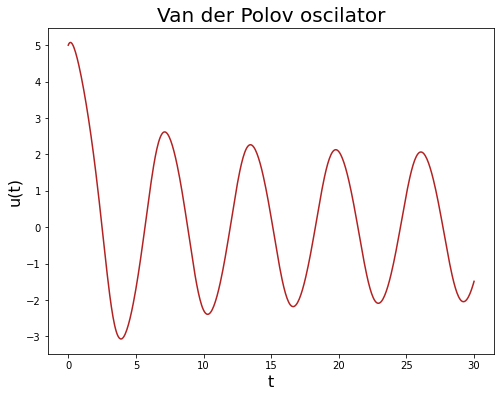

In [3]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Van der Polov oscilator', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [4]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt,2) # koristi se kasnije kod funkcije TrainSTRidge

ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])
descr

['', 'u_t', 'u', 'u^2', 'uu_t', 'u^2u_t']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [5]:
# Solve with STRidge
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (0.099726 +0.000000i)u_t
    + (-0.999290 +0.000000i)u
    + (-0.099848 +0.000000i)u^2u_t
   


In [6]:
err1 = abs((0.1 -  w[1][0])/0.1*100)
print("Greška parametra uz član u_t dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print(err1, '%\n')

err2 = abs((-1 -  w[2][0])*100)
print("Greška parametra uz član u dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print(err2, '%\n')

err3 = abs((-0.1 -  w[5][0])/0.1*100)
print("Greška parametra uz član u^2u_t dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print(err3, '%')

Greška parametra uz član u_t dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

0.2744899655012095 %

Greška parametra uz član u dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

0.07100507408895895 %

Greška parametra uz član u^2u_t dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

0.1520348034673713 %


Jednadžba $u_{tt} = 0.1 u_t - u - 0.1 u^2 u_t$ je dosta dobro rekonstruirana, ali tek nakon što je broj točaka u danom vremenskom intervalu $[0,50]$ povećan na N=500.

## Identificiramo istu dinamiku ali sa dodanim šumom na podatcima:

Jedina razlika od primjera gore je da metoda konačnih razlika ne radi dobro za podatke sa šumom pa koristimo polinomijalnu interpolaciju. Sa deg_x ili deg_t i width_x i width_t određujemo stupanj polinoma i broj točaka za deriviranje po x i t. Nažalost, rezultati mogu biti osjetljivi na ove veličine.

In [7]:
np.random.seed(0)
u_sum = u + np.random.normal(loc=0, scale=0.05, size=(u.shape[0],u.shape[1]))

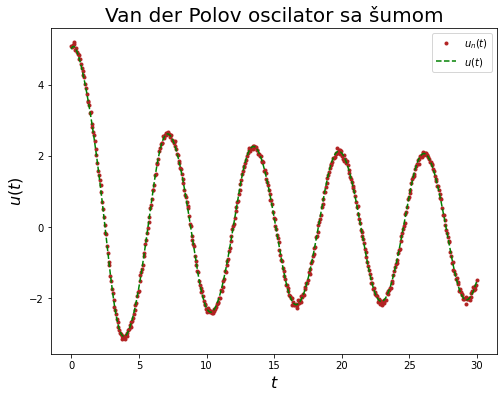

In [8]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u_sum[0,:],'.',color='firebrick',label='$u_n(t)$')
plt.plot(t,u[0,:],'--',color='green',label='$u(t)$')
plt.title('Van der Polov oscilator sa šumom', fontsize = 20)
plt.xlabel('$t$', fontsize = 16)
plt.ylabel('$u(t)$', fontsize = 16)
plt.legend()

In [9]:
def trim(u, d): #funkcija koja treba kasnije kako bi algoritam funkcionirao
    ind = np.arange(0, len(u))
    u_trim = np.delete(u, np.concatenate((ind[:d],ind[-d:])))
    return u_trim

In [10]:
m = len(x)
n = len(t)
podatci = []
run = 10

width = 5 # sirina prozora kod PolyDiff funkcije

for k in range(run):
    np.random.seed(k)
    un = u + np.random.normal(loc=0, scale=0.05, size=(u.shape[0],u.shape[1]))

    unt = np.zeros((m,n-2*width), dtype=np.complex64)
    untt = np.zeros((m,n-2*width), dtype=np.complex64)
    ones = np.ones((m,n), dtype=np.complex64)

    for i in range(m):
        unt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,0]
        untt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,1] # koristi se kasnije kod funkcije TrainSTRidge

    un = trim(un[0,:], width)
    ones = trim(ones[0,:], width)

    unt = np.reshape(unt, (-1,1), order='F')
    untt = np.reshape(untt, (-1,1), order='F')

    X_ders = np.hstack([np.ones((n*m-2*width,1)), unt])
    X_data = np.hstack([np.reshape(un, (-1,1), order='F')])
    derivatives_description = ['','u_t']

    X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])

    w = TrainSTRidge(X,untt,10**-5,0.1)
    podatci.append(w)
descr

['', 'u_t', 'u', 'u^2', 'uu_t', 'u^2u_t']

In [11]:
for i in range(run):
    print("PDJ dobivena pomoću STRidge:")
    print_pde(podatci[i], descr)

PDJ dobivena pomoću STRidge:
u_tt = (0.065141 +0.000000i)u_t
    + (-0.974764 +0.000000i)u
    + (-0.092943 +0.000000i)u^2u_t
   
PDJ dobivena pomoću STRidge:
u_tt = (0.083115 +0.000000i)u_t
    + (-0.974592 +0.000000i)u
    + (-0.090748 +0.000000i)u^2u_t
   
PDJ dobivena pomoću STRidge:
u_tt = (-0.009754 +0.000000i)
    + (0.060534 +0.000000i)u_t
    + (-0.996845 +0.000000i)u
    + (0.014735 +0.000000i)u^2
    + (-0.009622 +0.000000i)uu_t
    + (-0.084303 +0.000000i)u^2u_t
   
PDJ dobivena pomoću STRidge:
u_tt = (-0.066383 +0.000000i)
    + (0.066090 +0.000000i)u_t
    + (-0.996663 +0.000000i)u
    + (0.023416 +0.000000i)u^2
    + (-0.011526 +0.000000i)uu_t
    + (-0.083146 +0.000000i)u^2u_t
   
PDJ dobivena pomoću STRidge:
u_tt = (-0.060558 +0.000000i)
    + (0.079035 +0.000000i)u_t
    + (-0.990013 +0.000000i)u
    + (0.015558 +0.000000i)u^2
    + (0.004135 +0.000000i)uu_t
    + (-0.087395 +0.000000i)u^2u_t
   
PDJ dobivena pomoću STRidge:
u_tt = (0.080927 +0.000000i)u_t
    + (-0.9

In [12]:
lista_koef1 = np.reshape(podatci, (run, len(descr)))[:,1].real
err1 = abs((0.1 - lista_koef1)/0.1*100)
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print("Srednja greška parametra uz član u_t:", np.mean(err1), '%')
print("Standardna devijacija srednje greške parametra uz član u_t:", np.std(err1), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

Srednja greška parametra uz član u_t: 25.741882553196803 %
Standardna devijacija srednje greške parametra uz član u_t: 12.201762820035558 %


In [13]:
lista_koef2 = np.reshape(podatci, (run, len(descr)))[:,2].real
err2 = abs((-1 - lista_koef2)/1*100)
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print("Srednja greška parametra uz član u^2u_t:", np.mean(err2), '%')
print("Standardna devijacija srednje greške parametra uz član u^2u_t:", np.std(err2), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

Srednja greška parametra uz član u^2u_t: 1.6193725038482731 %
Standardna devijacija srednje greške parametra uz član u^2u_t: 1.1064509919597048 %


In [14]:
lista_koef3 = np.reshape(podatci, (run, len(descr)))[:,5].real
err3 = abs((-0.1 - lista_koef3)/0.1*100)
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print("Srednja greška parametra uz član u:", np.mean(err3), '%')
print("Standardna devijacija srednje greške parametra uz član u:", np.std(err3), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

Srednja greška parametra uz član u: 11.301361004936442 %
Standardna devijacija srednje greške parametra uz član u: 5.292914765975978 %


# Srednja jednadžba:
Jednadžba dobivena tako da se uzme srednja vrijednost dobivenih koeficijenata u svim iteracijama.

In [15]:
mean_podatci = np.mean(podatci, axis=0)
print("Srednja PDJ dobivena pomoću STRidge:")
print_pde(mean_podatci, descr)

Srednja PDJ dobivena pomoću STRidge:
u_tt = (-0.016188 +0.000000i)
    + (0.076330 +0.000000i)u_t
    + (-0.983806 +0.000000i)u
    + (0.006127 +0.000000i)u^2
    + (-0.002214 +0.000000i)uu_t
    + (-0.088699 +0.000000i)u^2u_t
   
